<a href="https://colab.research.google.com/github/allan7yin/Deep-Learning/blob/main/computer_vision/image_segmentation/advanced_comp_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Segmentation
In this notebook, we'll look at image segmentation. Perhaps also going into object detection as well.

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-02-06 01:11:06--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-02-06 01:11:07--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-02-06 01:11:08--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

Now, let's import this dataset

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

# Get the filenames in our data directories
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir) if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

Let's quickly take a look and see what this input looks like:

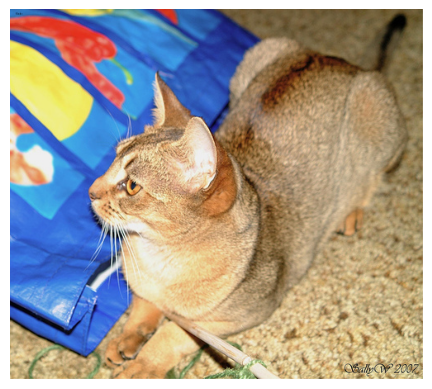

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

And here is the corresponding segmentation mask

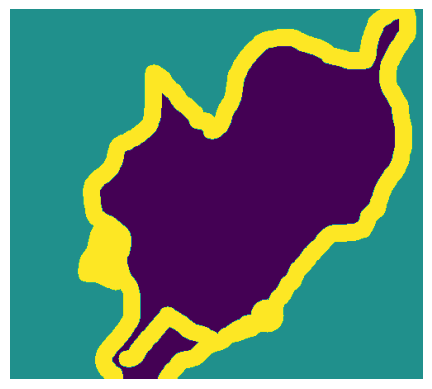

In [4]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:,:,0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)


Now, let's load our input and targets in 2 NumPy arrays, and let's split them into training and validation data sets.

In [5]:
import numpy as np
import random

img_size = (200,200)
num_imgs = len(input_img_paths)

# first randomly shuffle the dataset, choose same seed so order is preserved
random.Random(7).shuffle(input_img_paths)
random.Random(7).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  img = img_to_array(
    load_img(path, target_size=img_size, color_mode="grayscale")) # grayscale, as the images are black/white -> colour not important for segmenting the image into different classes
  img = img.astype("uint8") - 1 # subtracting 1 so that labels become 0,1,2
  return img

# intialize NumpyArrays
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

# arrays now have images in them (represnted as arrays)
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

Now that we have our data formatted correctly, we will definet the model:

In [6]:
from tensorflow import keras
from keras import layers

def build_model(img_size, num_classes):
  #  If img_size is (200, 200), adding (3,) to it results in a new tuple (200, 200, 3), since each pixel has (R,G,B) depth
  inputs = keras.Input(shape=img_size + (3,))
  # re-scale: normalize the values to [0,1]
  x = layers.Rescaling(1./255)(inputs)

  # Conv2D block
  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

  # Conv2DTranspose block
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
  model = keras.Model(inputs, outputs)
  return model

model = build_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [7]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
	keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
																	save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets, epochs=50,
										callbacks=callbacks,
										batch_size=64,
										validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 107s 831ms/step - loss: 0.9448 - val_loss: 0.9137
Epoch 2/50
100/100 [==============================] - 58s 584ms/step - loss: 0.8823 - val_loss: 0.8376
Epoch 3/50
100/100 [==============================] - 58s 584ms/step - loss: 0.8364 - val_loss: 0.8104
Epoch 4/50
100/100 [==============================] - 58s 583ms/step - loss: 0.8199 - val_loss: 0.7910
Epoch 5/50
100/100 [==============================] - 58s 582ms/step - loss: 0.8013 - val_loss: 0.8227
Epoch 6/50
100/100 [==============================] - 58s 584ms/step - loss: 0.7843 - val_loss: 0.7446
Epoch 7/50
100/100 [==============================] - 58s 583ms/step - loss: 0.7730 - val_loss: 0.7286
Epoch 8/50
100/100 [==============================] - 58s 583ms/step - loss: 0.7422 - val_loss: 0.7173
Epoch 9/50
100/100 [==============================] - 58s 584ms/step - loss: 0.7308 - val_loss: 0.6965
Epoch 10/50
100/100 [==============================] - 58s 582ms/step - 

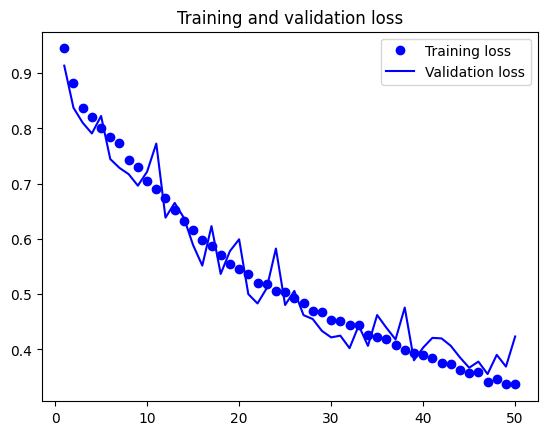

In [8]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


We begin overfitting at around the 25th epoch. Reload best performing model, and next we'll see how to use this model to predict a segmentation task:

1/1 [==============================] - 0s 166ms/step


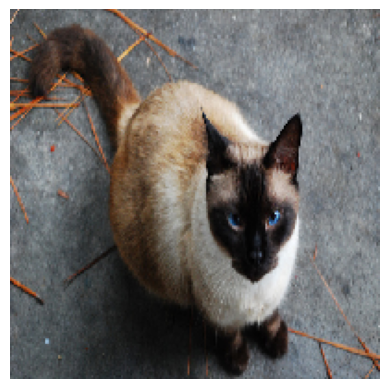

In [19]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i=4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

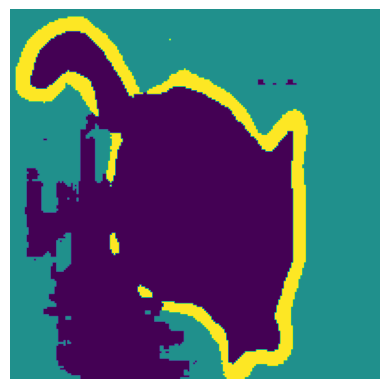

In [20]:
# now let's see what the prediction looks like
display_mask(mask)